## Summary of results
__Selected features:__

['delta_age',
'delta_sig_strikes_absorbed_pm',
'delta_sig_strikes_accuracy',
'delta_sig_strikes_defended',
'delta_sig_strikes_landed_pm',
'delta_submission_avg_attempted_per15m',
'delta_takedown_avg_per15m',
'delta_takedown_defence']

__Remarks__
* Delta features adequately summarise information - negligible difference in results with delta features (delta_* ) vs raw individual features (fighter1_* , fighter2_*)
* Features with highest importance are significant striking stats (accuracy, LPM) and also surprisingly the difference in age.
* Features with lowest importance were height, reach, stance and weight class (removed)
* Surprisingly, takedown accuracy was of lower importance - it seems that takedown attempts is more important

__Model results__
| Model iteration | Error metrics | Result |
| --- | --- | ---
| xgboost, all features | 10-fold nested CV, accuracy | 0.649|
| xgboost, attributes + delta features, removing <br /> height, reach, stance, weight class| 10-fold nested CV, accuracy | 0.644|
| xgboost, delta features only, removing <br /> height, reach, stance, weight class | 10-fold nested CV, accuracy | 0.647|
| xgboost, above but also removing takedown accuracy and sig strikes <br /> defended (RFECV - ignored hyperparameters)| 10-fold nested CV, accuracy | 0.644|

### Imports

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pprint import pprint
from collections import defaultdict

import xgboost as xgb
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [4]:
from ufc import constants, load_data

In [5]:
# Load data
df = load_data.read_prepped_data()

response = "outcome"
k = 10

### Functions
Functionalise GBM fit

In [6]:
def test_xgboost(data, features, categorical_features, cv=5, benchmark_random_feature=True):
    df = data.copy()

    le = LabelEncoder()
    df['outcome'] = le.fit_transform(df['outcome'])

    # True - add random feature to benchmark feature importance to
    if benchmark_random_feature:
        random_state = np.random.RandomState(constants.SEED)
        df['RANDOM_FEATURE'] = random_state.random(size=data.shape[0])
        features = features + ["RANDOM_FEATURE"]

    # One-hot encode categorical features
    numeric_features = [col for col in features if col not in categorical_features]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numeric_features),
            ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_features)
            # Note - handle_unknown="ignore" means that categories in validation not seen during training
            # of OneHotEncoder will get ignored (filled with 0)
        ])

    # Split data into X, y
    X = df[features]
    y = df['outcome']

    # Define hyperparam grid for grid search
    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 4, 5],
    }

    # Below uses nested cross validation
    # Outer loop - split into train / test
    outer_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=constants.SEED)

    best_models = []
    cross_val_metrics = []

    # Inner loop - split train into training and validation for hyperparameter tuning, then use test
    # from outer loop to get error
    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Split the training data into training and validation sets for hyperparameter tuning
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=constants.SEED)

        # Initialise xgb model
        xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=constants.SEED)

        # Create pipeline with preprocessor and classifier
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', xgb_model)
        ])

        # Hyperparam tuning - GridSearchCV
        grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
        grid_search.fit(X_val, y_val)

        # Get the best model
        best_model = grid_search.best_estimator_

        # Then train on training set
        best_model.fit(X_train, y_train)

        # Get test error
        y_pred = best_model.predict(X_test)

        # Compute accuracy, confusion matrix, and classification report
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred)

        # Store best model and evaluation metrics for fold
        best_models.append(best_model)
        cross_val_metrics.append({
            'Accuracy': accuracy,
            'Confusion Matrix': conf_matrix,
            'Classification Report': class_report
        })

    return best_models, cross_val_metrics, numeric_features

In [7]:
def summarise_mean_cv_error(cross_val_metrics):
    """Summarise error metrics across folds"""
    # Initialize lists to store individual metrics for each fold
    accuracies = []
    confusion_matrices = []

    # Initialize dictionaries to store classification report metrics for each fold
    precision = defaultdict(list)
    recall = defaultdict(list)
    f1_score = defaultdict(list)
    support = defaultdict(list)

    for fold in cross_val_metrics:
        accuracies.append(fold['Accuracy'])
        confusion_matrices.append(fold['Confusion Matrix'])

        # Parse and accumulate classification report metrics
        cr = fold['Classification Report'].split('\n')
        weighted_avg_index = next((i for i, s in enumerate(cr) if s.startswith('weighted avg')), None)
        weighted_avg_cr = cr[weighted_avg_index].split()

        label = weighted_avg_cr[0]
        precision[label].append(float(weighted_avg_cr[-4]))
        recall[label].append(float(weighted_avg_cr[-3]))
        f1_score[label].append(float(weighted_avg_cr[-2]))
        support[label].append(int(weighted_avg_cr[-1]))

    # Calculate the mean accuracy
    mean_accuracy = np.mean(accuracies)

    # Calculate the mean confusion matrix
    mean_confusion_matrix = np.mean(confusion_matrices, axis=0)

    # Calculate the mean classification report metrics
    mean_precision = {label: np.mean(precision[label]) for label in precision}['weighted']
    mean_recall = {label: np.mean(recall[label]) for label in recall}["weighted"]
    mean_f1_score = {label: np.mean(f1_score[label]) for label in f1_score}["weighted"]

    mean_classification_report = {
        "Precision": mean_precision,
        "Recall": mean_recall,
        "F1 Score": mean_f1_score,
    }

    return {
        'Mean Accuracy': mean_accuracy,
        'Mean Confusion Matrix': mean_confusion_matrix,
        'Mean Classification Report': mean_classification_report
    }

In [8]:
def print_error_metrics(error_metrics):
    print("CV error ---")
    print("Accuracy:", error_metrics["Mean Accuracy"])
    print("Confusion Matrix:\n", error_metrics["Mean Confusion Matrix"])
    print("Classification Report:\n", error_metrics["Mean Classification Report"])

In [9]:
def summarise_mean_feature_importance(models):

    # Initialize a list to store feature importances for each fold
    feature_importance_per_fold = []

    # Calculate feature importance for each fold's best model
    for model in models:
        feature_importance_per_fold.append(model.named_steps['classifier'].feature_importances_)

    # Calculate the mean feature importance across folds
    mean_feature_importance = np.mean(feature_importance_per_fold, axis=0)

    return mean_feature_importance

In [10]:
def plot_feature_importance(xgboost_model, numeric_features, feature_importances=None):

    # when no CV
    if feature_importances is None:
        feature_importances = xgboost_model.named_steps['classifier'].feature_importances_
    
    # not CV
    if isinstance(xgboost_model, list):
        one_hot_encoder = xgboost_model[0].named_steps['preprocessor'].named_transformers_['cat']
    # CV
    else:
        one_hot_encoder = xgboost_model.named_steps['preprocessor'].named_transformers_['cat']
    # Check if any categorical features
    if hasattr(one_hot_encoder, 'categories_'):
        input_features = one_hot_encoder.get_feature_names_out()
    else:
        input_features = []
        
    feature_names = numeric_features + list(input_features)

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    feature_importance_df = feature_importance_df\
        .sort_values(by='Importance', ascending=False)\
        .reset_index(drop=True)

    plt.figure(figsize=(10, 10))

    if 'RANDOM_FEATURE' in feature_names:
        random_feature_index = feature_importance_df[feature_importance_df["Feature"] == "RANDOM_FEATURE"].index
        print(random_feature_index)
        plt.axhline(y=random_feature_index - 0.5, color='k', linestyle='--', label='RANDOM_FEATURE')

    plt.barh(range(len(feature_importance_df)), feature_importance_df['Importance'], align='center')
    plt.yticks(range(len(feature_importance_df)), feature_importance_df['Feature'])
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()
    plt.show()


### Test model iterations
Different feature sets

All features

CV error ---
Accuracy: 0.6492633228840126
Confusion Matrix:
 [[101.   57.4]
 [ 54.6 106.3]]
Classification Report:
 {'Precision': 0.649, 'Recall': 0.649, 'F1 Score': 0.648}
Int64Index([32], dtype='int64')


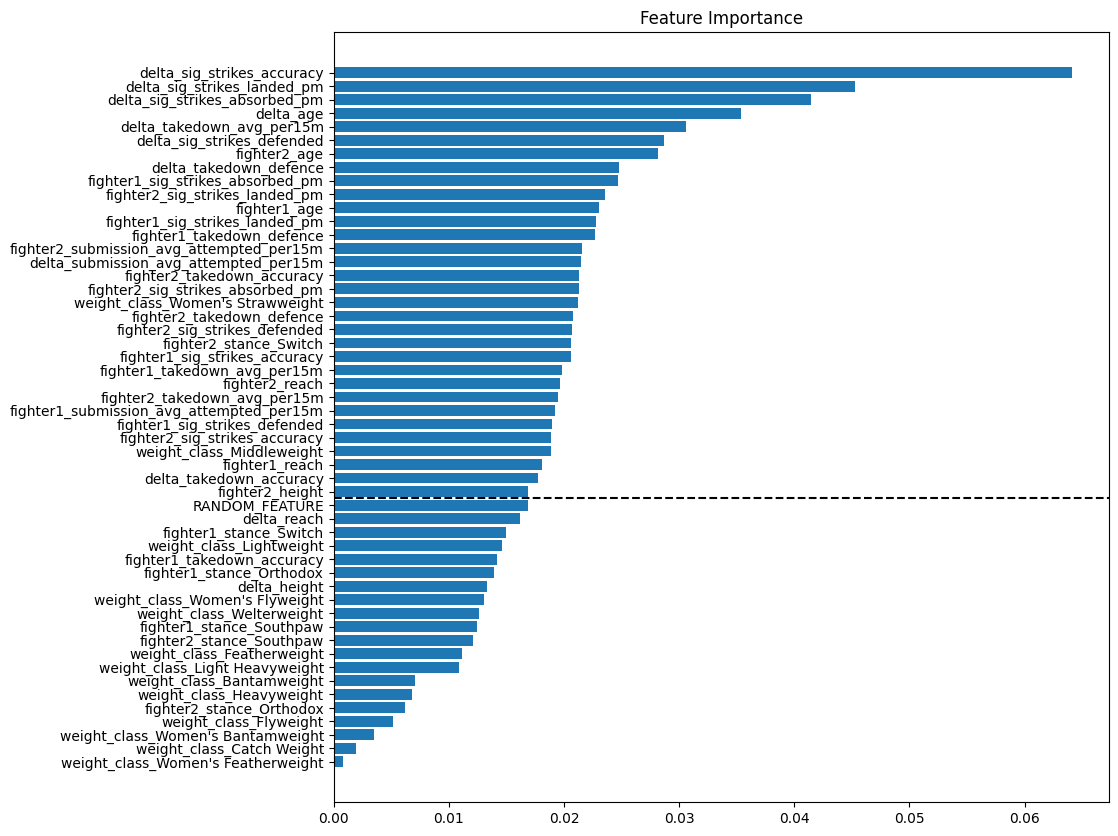

In [11]:
# Define features to test
features = [
    'weight_class',
    'fighter1_reach', 'fighter1_stance', 'fighter1_sig_strikes_landed_pm',
    'fighter1_sig_strikes_accuracy', 'fighter1_sig_strikes_absorbed_pm',
    'fighter1_sig_strikes_defended', 'fighter1_takedown_avg_per15m',
    'fighter1_takedown_accuracy', 'fighter1_takedown_defence',
    'fighter1_submission_avg_attempted_per15m', 'fighter2_height',
    'fighter2_reach',
    'fighter2_stance', 'fighter2_sig_strikes_landed_pm',
    'fighter2_sig_strikes_accuracy', 'fighter2_sig_strikes_absorbed_pm',
    'fighter2_sig_strikes_defended', 'fighter2_takedown_avg_per15m',
    'fighter2_takedown_accuracy', 'fighter2_takedown_defence',
    'fighter2_submission_avg_attempted_per15m', 'fighter1_age',
    'fighter2_age', 'delta_height', 'delta_age', 'delta_reach',
    'delta_sig_strikes_landed_pm', 'delta_sig_strikes_accuracy',
    'delta_sig_strikes_absorbed_pm', 'delta_sig_strikes_defended',
    'delta_takedown_avg_per15m', 'delta_takedown_accuracy',
    'delta_takedown_defence', 'delta_submission_avg_attempted_per15m',
]

# Pull out categorical features which need one hot encoding
categorical_features = ['weight_class', "fighter1_stance", "fighter2_stance"]

# Train model and return test errors
xgb_models, error_metrics, numeric_features = test_xgboost(
    df, features, categorical_features, cv=k, benchmark_random_feature=True
)

# Summarise error metrics across folds
summarised_error_metrics = summarise_mean_cv_error(error_metrics)
print_error_metrics(summarised_error_metrics)

# Summarise feature importance across folds
summarised_feature_importance = summarise_mean_feature_importance(xgb_models)
plot_feature_importance(xgb_models, numeric_features, summarised_feature_importance)

All features - take out random feature to get true error

CV error ---
Accuracy: 0.6492623432601882
Confusion Matrix:
 [[101.3  57.1]
 [ 54.9 106. ]]
Classification Report:
 {'Precision': 0.649, 'Recall': 0.649, 'F1 Score': 0.649}


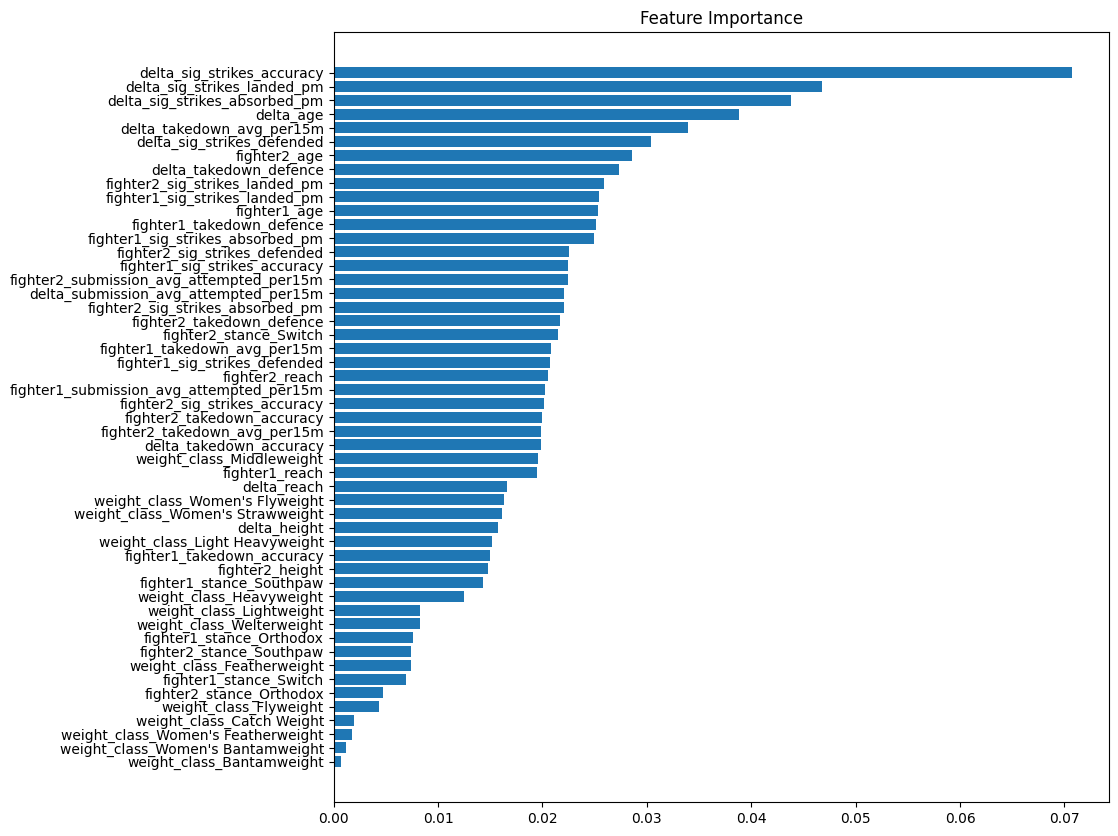

In [12]:
# Define features to test
features = [
    'weight_class',
    'fighter1_reach', 'fighter1_stance', 'fighter1_sig_strikes_landed_pm',
    'fighter1_sig_strikes_accuracy', 'fighter1_sig_strikes_absorbed_pm',
    'fighter1_sig_strikes_defended', 'fighter1_takedown_avg_per15m',
    'fighter1_takedown_accuracy', 'fighter1_takedown_defence',
    'fighter1_submission_avg_attempted_per15m', 'fighter2_height',
    'fighter2_reach',
    'fighter2_stance', 'fighter2_sig_strikes_landed_pm',
    'fighter2_sig_strikes_accuracy', 'fighter2_sig_strikes_absorbed_pm',
    'fighter2_sig_strikes_defended', 'fighter2_takedown_avg_per15m',
    'fighter2_takedown_accuracy', 'fighter2_takedown_defence',
    'fighter2_submission_avg_attempted_per15m', 'fighter1_age',
    'fighter2_age', 'delta_height', 'delta_age', 'delta_reach',
    'delta_sig_strikes_landed_pm', 'delta_sig_strikes_accuracy',
    'delta_sig_strikes_absorbed_pm', 'delta_sig_strikes_defended',
    'delta_takedown_avg_per15m', 'delta_takedown_accuracy',
    'delta_takedown_defence', 'delta_submission_avg_attempted_per15m',
]

# Pull out categorical features which need one hot encoding
categorical_features = ['weight_class', "fighter1_stance", "fighter2_stance"]

# Train model and return test errors
xgb_models, error_metrics, numeric_features = test_xgboost(
    df, features, categorical_features, cv=k, benchmark_random_feature=False
)

# Summarise error metrics across folds
summarised_error_metrics = summarise_mean_cv_error(error_metrics)
print_error_metrics(summarised_error_metrics)

# Summarise feature importance across folds
summarised_feature_importance = summarise_mean_feature_importance(xgb_models)
plot_feature_importance(xgb_models, numeric_features, summarised_feature_importance)

Remove least importance features - weight class, height and reach

CV error ---
Accuracy: 0.6445601489028213
Confusion Matrix:
 [[100.4  58. ]
 [ 55.5 105.4]]
Classification Report:
 {'Precision': 0.644, 'Recall': 0.644, 'F1 Score': 0.644}


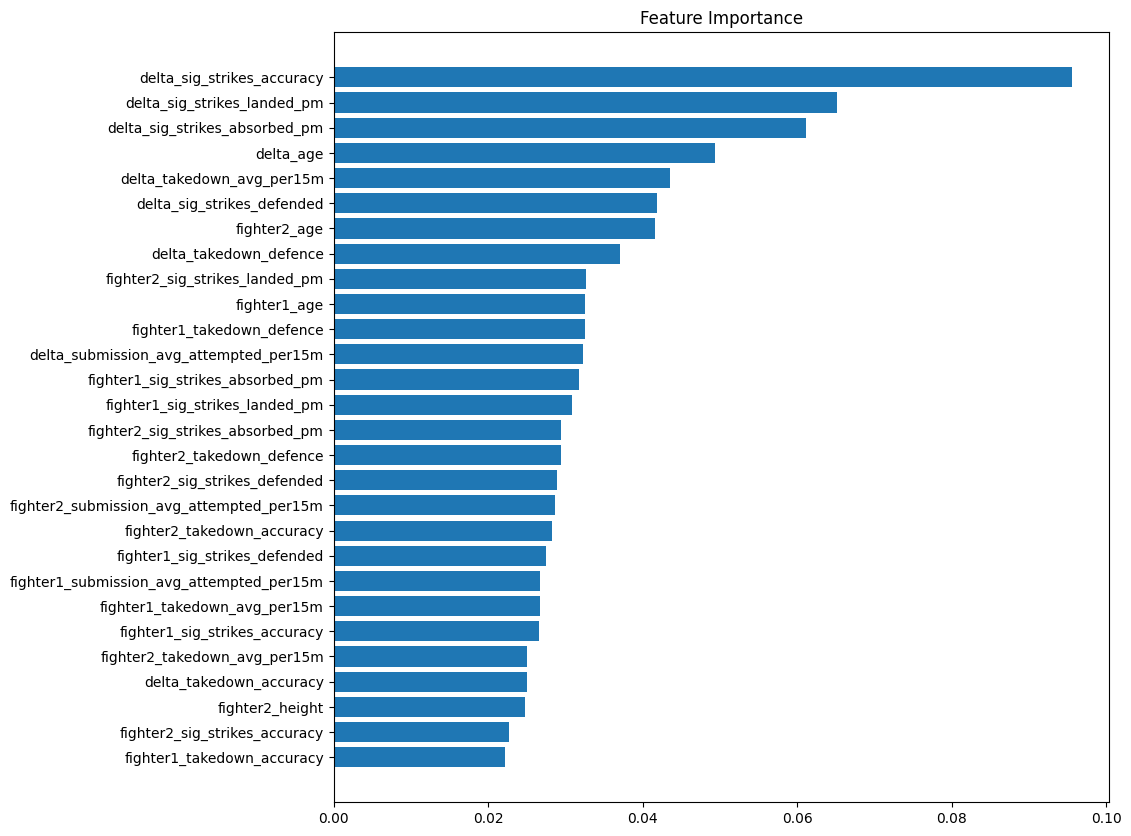

In [13]:
# Define features to test
features = [
    'fighter1_sig_strikes_landed_pm',
    'fighter1_sig_strikes_accuracy', 'fighter1_sig_strikes_absorbed_pm',
    'fighter1_sig_strikes_defended', 'fighter1_takedown_avg_per15m',
    'fighter1_takedown_accuracy', 'fighter1_takedown_defence',
    'fighter1_submission_avg_attempted_per15m', 'fighter2_height',

    'fighter2_sig_strikes_landed_pm',
    'fighter2_sig_strikes_accuracy', 'fighter2_sig_strikes_absorbed_pm',
    'fighter2_sig_strikes_defended', 'fighter2_takedown_avg_per15m',
    'fighter2_takedown_accuracy', 'fighter2_takedown_defence',
    'fighter2_submission_avg_attempted_per15m', 'fighter1_age',
    'fighter2_age',
    
    'delta_age',
    'delta_sig_strikes_landed_pm', 'delta_sig_strikes_accuracy',
    'delta_sig_strikes_absorbed_pm', 'delta_sig_strikes_defended',
    'delta_takedown_avg_per15m', 'delta_takedown_accuracy',
    'delta_takedown_defence', 'delta_submission_avg_attempted_per15m',
]

# Pull out categorical features which need one hot encoding
categorical_features = []

# Train model and return test errors
xgb_models, error_metrics, numeric_features = test_xgboost(
    df, features, categorical_features, cv=k, benchmark_random_feature=False
)

# Summarise error metrics across folds
summarised_error_metrics = summarise_mean_cv_error(error_metrics)
print_error_metrics(summarised_error_metrics)

# Summarise feature importance across folds
summarised_feature_importance = summarise_mean_feature_importance(xgb_models)
plot_feature_importance(xgb_models, numeric_features, summarised_feature_importance)

Remove individual fighter attributes - use delta features only

CV error ---
Accuracy: 0.6473834247648903
Confusion Matrix:
 [[100.9  57.5]
 [ 55.1 105.8]]
Classification Report:
 {'Precision': 0.649, 'Recall': 0.648, 'F1 Score': 0.648}


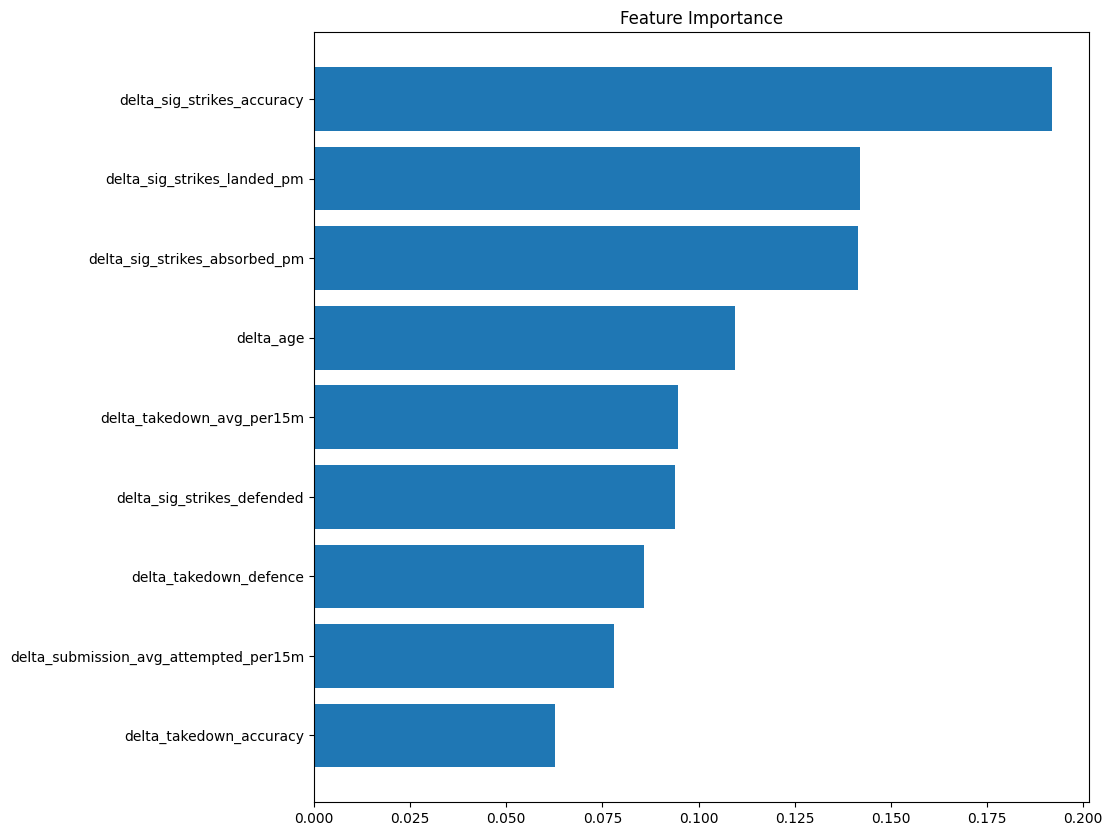

In [14]:
# Define features to test
features = [
    'delta_age',
    'delta_sig_strikes_landed_pm', 'delta_sig_strikes_accuracy',
    'delta_sig_strikes_absorbed_pm', 'delta_sig_strikes_defended',
    'delta_takedown_avg_per15m', 'delta_takedown_accuracy',
    'delta_takedown_defence', 'delta_submission_avg_attempted_per15m',
]

# Pull out categorical features which need one hot encoding
categorical_features = []

# Train model and return test errors
xgb_models, error_metrics, numeric_features = test_xgboost(
    df, features, categorical_features, cv=k, benchmark_random_feature=False
)

# Summarise error metrics across folds
summarised_error_metrics = summarise_mean_cv_error(error_metrics)
print_error_metrics(summarised_error_metrics)

# Summarise feature importance across folds
summarised_feature_importance = summarise_mean_feature_importance(xgb_models)
plot_feature_importance(xgb_models, numeric_features, summarised_feature_importance)

### RFECV

In [20]:
def select_rfecv(data, features, categorical_features, folds):

    df = data.copy()
    df = df[features + ["outcome"]]
    # One-hot encode the categorical features this way - RFECV doesn't seem to like preprocessing
    df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

    le = LabelEncoder()
    df['outcome'] = le.fit_transform(df['outcome'])

    features = df.columns.difference(['outcome'])
    X = df[features]
    y = df['outcome']

    xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=constants.SEED)

    # set up RFECV
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=constants.SEED)
    rfecv = RFECV(estimator=xgb_model, step=1, cv=cv, scoring='accuracy')
    rfecv.fit(X, y)

    selected_features = [feature for i, feature in enumerate(X.columns) if rfecv.support_[i]]
    dropped_features = [feature for i, feature in enumerate(X.columns) if not rfecv.support_[i]]

    # return best
    return {
        "selected_features": selected_features,
        "dropped_features": dropped_features,
    }

Classic - automatic feature selection returns a mess you could never show a stakeholder or justify 😂

In [21]:
features = [
    'weight_class',
    'fighter1_reach', 'fighter1_stance', 'fighter1_sig_strikes_landed_pm',
    'fighter1_sig_strikes_accuracy', 'fighter1_sig_strikes_absorbed_pm',
    'fighter1_sig_strikes_defended', 'fighter1_takedown_avg_per15m',
    'fighter1_takedown_accuracy', 'fighter1_takedown_defence',
    'fighter1_submission_avg_attempted_per15m', 'fighter2_height',
    'fighter2_reach',
    'fighter2_stance', 'fighter2_sig_strikes_landed_pm',
    'fighter2_sig_strikes_accuracy', 'fighter2_sig_strikes_absorbed_pm',
    'fighter2_sig_strikes_defended', 'fighter2_takedown_avg_per15m',
    'fighter2_takedown_accuracy', 'fighter2_takedown_defence',
    'fighter2_submission_avg_attempted_per15m', 'fighter1_age',
    'fighter2_age', 'delta_height', 'delta_age', 'delta_reach',
    'delta_sig_strikes_landed_pm', 'delta_sig_strikes_accuracy',
    'delta_sig_strikes_absorbed_pm', 'delta_sig_strikes_defended',
    'delta_takedown_avg_per15m', 'delta_takedown_accuracy',
    'delta_takedown_defence', 'delta_submission_avg_attempted_per15m',
]

categorical_features = ['weight_class', "fighter1_stance", "fighter2_stance"]

selected = select_rfecv(df, features, categorical_features, folds=10)
pprint(selected)

{'dropped_features': ['fighter1_reach',
                      'fighter1_sig_strikes_absorbed_pm',
                      'fighter1_sig_strikes_accuracy',
                      'fighter1_stance_Southpaw',
                      'fighter1_takedown_accuracy',
                      'fighter2_sig_strikes_absorbed_pm',
                      'fighter2_sig_strikes_defended',
                      'weight_class_Catch Weight',
                      'weight_class_Flyweight',
                      'weight_class_Welterweight',
                      "weight_class_Women's Bantamweight",
                      "weight_class_Women's Featherweight"],
 'selected_features': ['delta_age',
                       'delta_height',
                       'delta_reach',
                       'delta_sig_strikes_absorbed_pm',
                       'delta_sig_strikes_accuracy',
                       'delta_sig_strikes_defended',
                       'delta_sig_strikes_landed_pm',
                       'delta_sub

In [22]:
selected["selected_features"]

['delta_age',
 'delta_height',
 'delta_reach',
 'delta_sig_strikes_absorbed_pm',
 'delta_sig_strikes_accuracy',
 'delta_sig_strikes_defended',
 'delta_sig_strikes_landed_pm',
 'delta_submission_avg_attempted_per15m',
 'delta_takedown_accuracy',
 'delta_takedown_avg_per15m',
 'delta_takedown_defence',
 'fighter1_age',
 'fighter1_sig_strikes_defended',
 'fighter1_sig_strikes_landed_pm',
 'fighter1_stance_Switch',
 'fighter1_submission_avg_attempted_per15m',
 'fighter1_takedown_avg_per15m',
 'fighter1_takedown_defence',
 'fighter2_age',
 'fighter2_height',
 'fighter2_reach',
 'fighter2_sig_strikes_accuracy',
 'fighter2_sig_strikes_landed_pm',
 'fighter2_stance_Southpaw',
 'fighter2_stance_Switch',
 'fighter2_submission_avg_attempted_per15m',
 'fighter2_takedown_accuracy',
 'fighter2_takedown_avg_per15m',
 'fighter2_takedown_defence',
 'weight_class_Featherweight',
 'weight_class_Heavyweight',
 'weight_class_Light Heavyweight',
 'weight_class_Lightweight',
 'weight_class_Middleweight',
 "w

We will do RFECV on manually reviewed features instead to see if any should be removed

In [23]:
features = [
    'delta_age',
    'delta_sig_strikes_landed_pm', 'delta_sig_strikes_accuracy',
    'delta_sig_strikes_absorbed_pm', 'delta_sig_strikes_defended',
    'delta_takedown_avg_per15m', 'delta_takedown_accuracy',
    'delta_takedown_defence', 'delta_submission_avg_attempted_per15m',
]
categorical_features = []

selected = select_rfecv(df, features, categorical_features, folds=10)

pprint(selected)

{'dropped_features': ['delta_sig_strikes_defended', 'delta_takedown_accuracy'],
 'selected_features': ['delta_age',
                       'delta_sig_strikes_absorbed_pm',
                       'delta_sig_strikes_accuracy',
                       'delta_sig_strikes_landed_pm',
                       'delta_submission_avg_attempted_per15m',
                       'delta_takedown_avg_per15m',
                       'delta_takedown_defence']}


CV error ---
Accuracy: 0.6442554858934169
Confusion Matrix:
 [[100.6  57.8]
 [ 55.8 105.1]]
Classification Report:
 {'Precision': 0.6449999999999999, 'Recall': 0.6439999999999999, 'F1 Score': 0.6439999999999999}


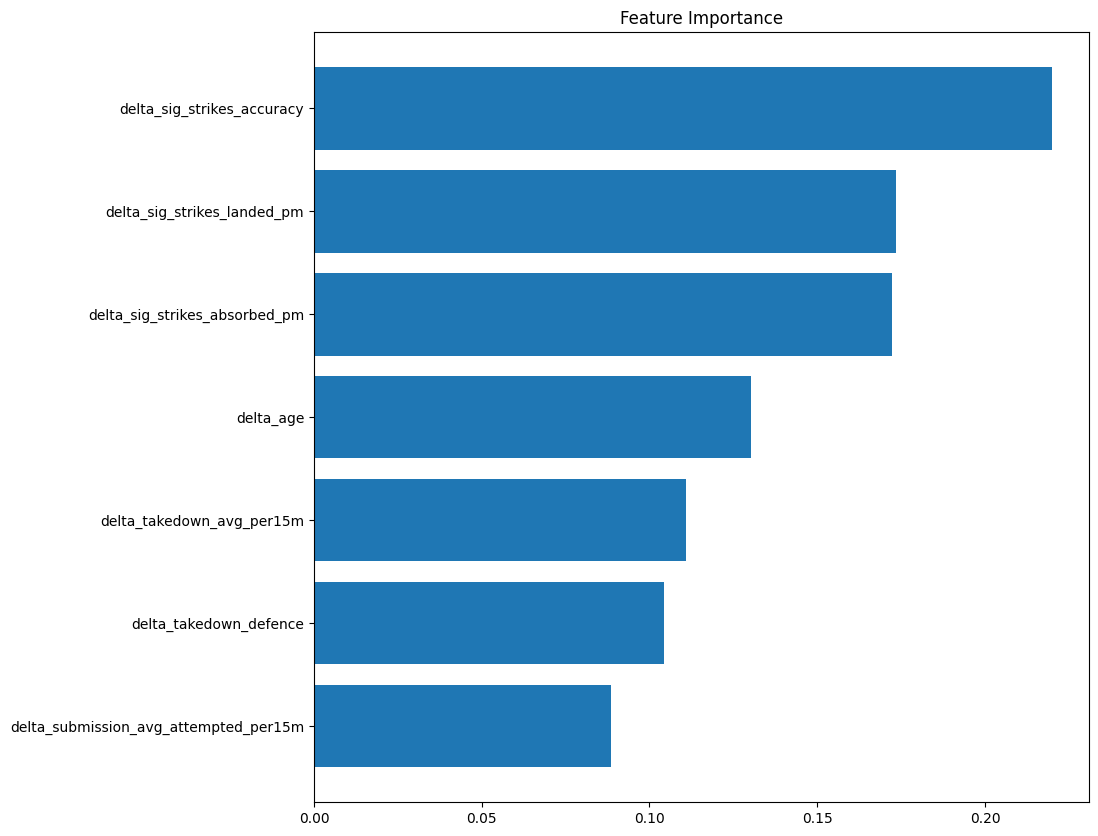

In [24]:
# Define features to test
features = selected["selected_features"]

# Pull out categorical features which need one hot encoding
categorical_features = []

# Train model and return test errors
xgb_models, error_metrics, numeric_features = test_xgboost(
    df, features, categorical_features, cv=k, benchmark_random_feature=False
)

# Summarise error metrics across folds
summarised_error_metrics = summarise_mean_cv_error(error_metrics)
print_error_metrics(summarised_error_metrics)

# Summarise feature importance across folds
summarised_feature_importance = summarise_mean_feature_importance(xgb_models)
plot_feature_importance(xgb_models, numeric_features, summarised_feature_importance)